# Task 2: Exploratory Data Analysis (EDA)
Analyze the patterns and factors influencing financial inclusion in Ethiopia.

In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
import os

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Dataset Overview
First, we load the unified dataset and summarize its contents.

In [7]:
df = pd.read_csv('../data/raw/ethiopia_fi_unified_data - ethiopia_fi_unified_data.csv')

print("--- Summary by Record Type ---")
print(df['record_type'].value_counts())

print("\n--- Summary by Pillar ---")
print(df['pillar'].value_counts(dropna=False))

print("\n--- Summary by Source Type ---")
print(df['source_type'].value_counts())

--- Summary by Record Type ---
record_type
observation    31
event          11
target          3
impact_link     2
Name: count, dtype: int64

--- Summary by Pillar ---
pillar
ACCESS           18
USAGE            12
NaN              11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

--- Summary by Source Type ---
source_type
operator      15
survey        10
regulator      8
research       5
policy         3
calculated     2
news           2
Name: count, dtype: int64


### 1.1 Temporal Coverage Heatmap
Visualizing which years have data for which indicators.

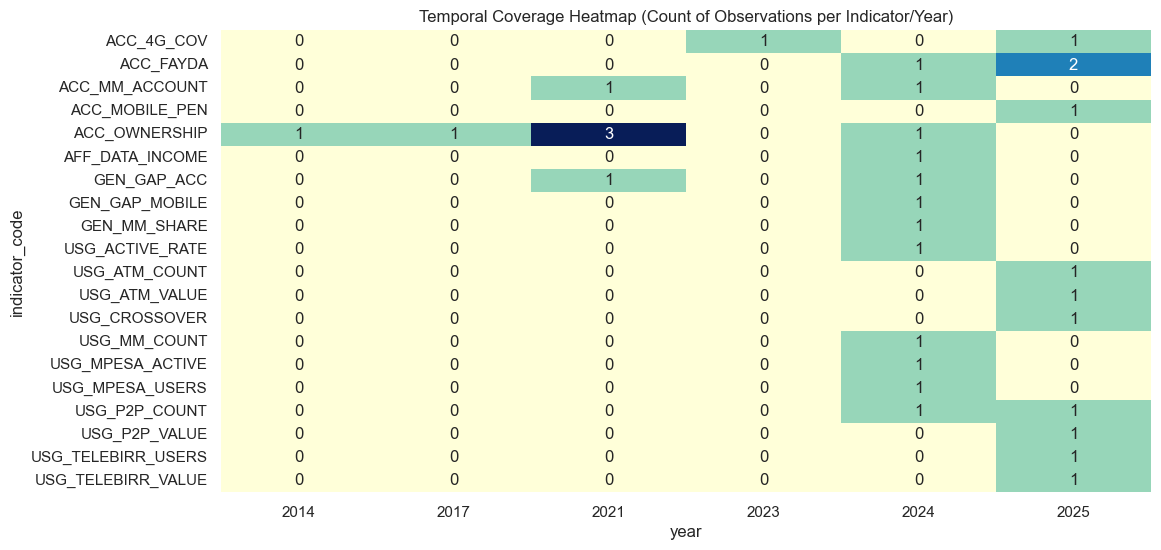

In [8]:
obs_df = df[df['record_type'] == 'observation'].copy()
obs_df['year'] = pd.to_datetime(obs_df['observation_date'], errors='coerce').dt.year

# Aggregate to see counts per indicator per year
coverage = obs_df.pivot_table(index='indicator_code', columns='year', values='value_numeric', aggfunc='count').fillna(0)

sns.heatmap(coverage, annot=True, cmap="YlGnBu", cbar=False)
plt.title("Temporal Coverage Heatmap (Count of Observations per Indicator/Year)")
plt.show()

### 1.2 Data Quality Assessment
Distribution of confidence levels.

C:\Users\My Device\AppData\Local\Temp\ipykernel_2968\375625777.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='confidence', palette='viridis')


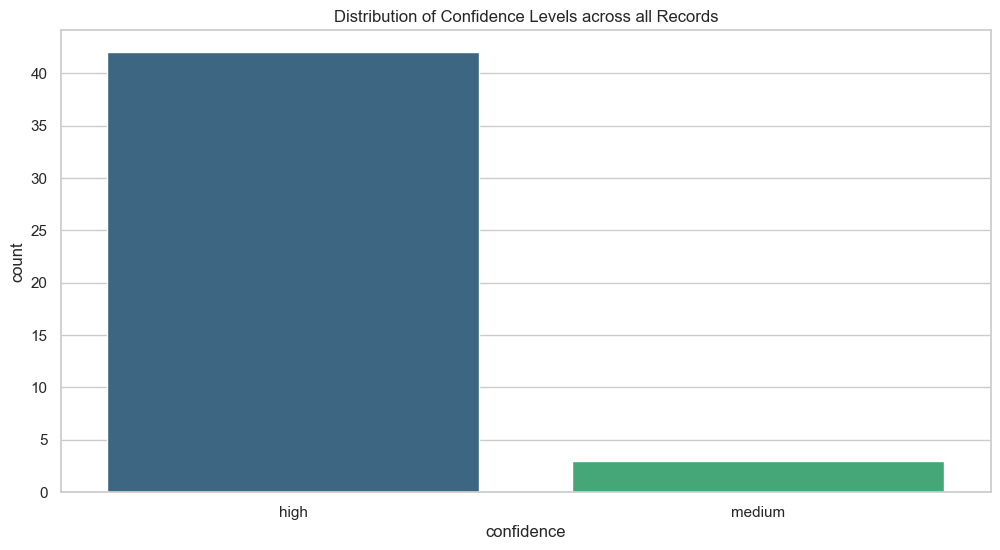

In [9]:
sns.countplot(data=df, x='confidence', palette='viridis')
plt.title("Distribution of Confidence Levels across all Records")
plt.show()

## 2. Access Analysis
Plotting Ethiopia's account ownership trajectory (2011-2024).

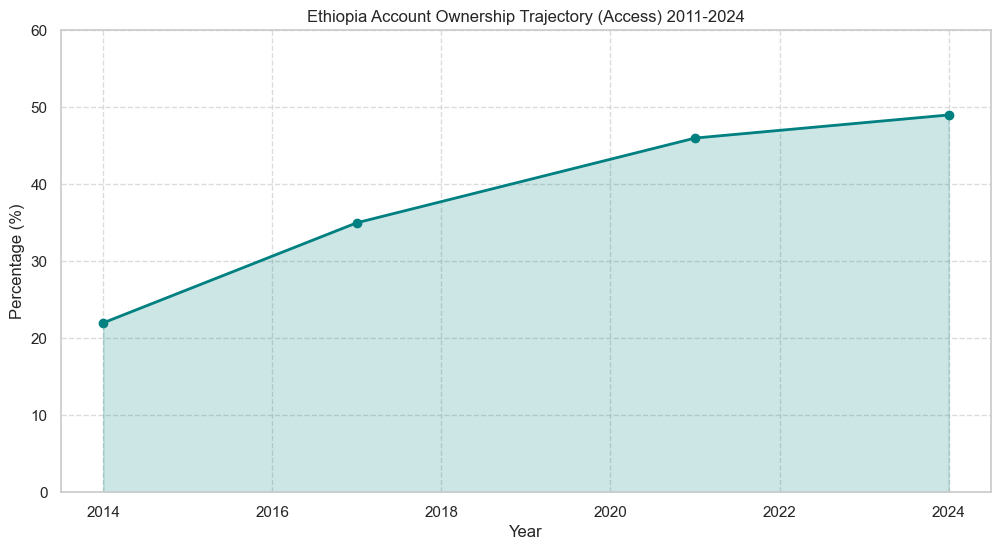

In [10]:
acc_df = obs_df[obs_df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('year')
acc_df = acc_df[acc_df['gender'] == 'all'] # Focus on national baseline

plt.plot(acc_df['year'], acc_df['value_numeric'], marker='o', linestyle='-', color='teal', linewidth=2)
plt.fill_between(acc_df['year'], acc_df['value_numeric'], alpha=0.2, color='teal')
plt.title("Ethiopia Account Ownership Trajectory (Access) 2011-2024")
plt.ylabel("Percentage (%)")
plt.xlabel("Year")
plt.ylim(0, 60)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 2.1 Growth Rates & The 2021-2024 Slowdown
Calculating percentage point changes between survey years.

Year-over-survey Change (pp):
   year  value_numeric  pp_change
0  2014           22.0        NaN
1  2017           35.0       13.0
2  2021           46.0       11.0
5  2024           49.0        3.0


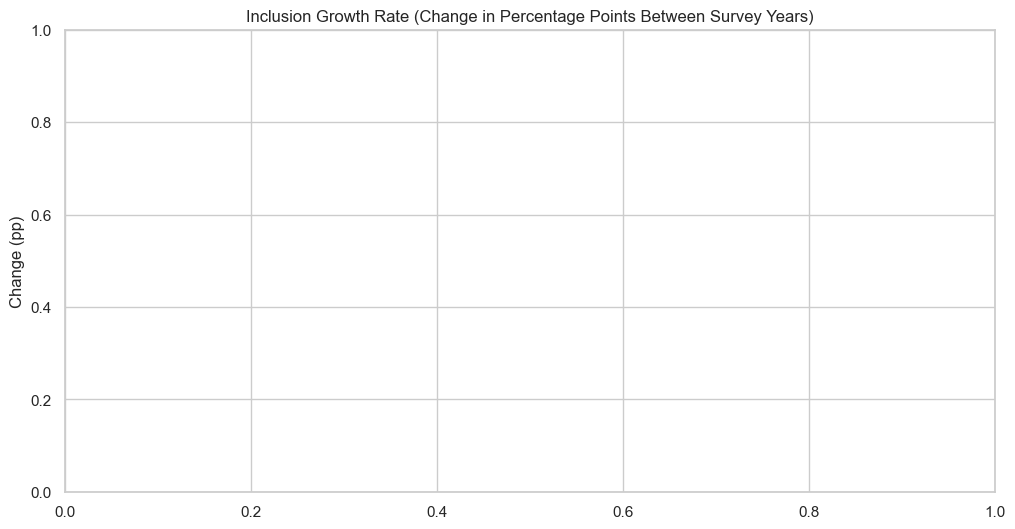

In [11]:
acc_df['pp_change'] = acc_df['value_numeric'].diff()
print("Year-over-survey Change (pp):")
print(acc_df[['year', 'value_numeric', 'pp_change']])

# Visualize the slowdown
sns.barplot(data=acc_df.dropna(), x='year', y='pp_change', color='coral')
plt.title("Inclusion Growth Rate (Change in Percentage Points Between Survey Years)")
plt.ylabel("Change (pp)")
plt.show()

### 2.2 Gender Gap Analysis
Comparing Male and Female account ownership in 2021.

C:\Users\My Device\AppData\Local\Temp\ipykernel_2968\1247180991.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_df, x='gender', y='value_numeric', palette='pastel')


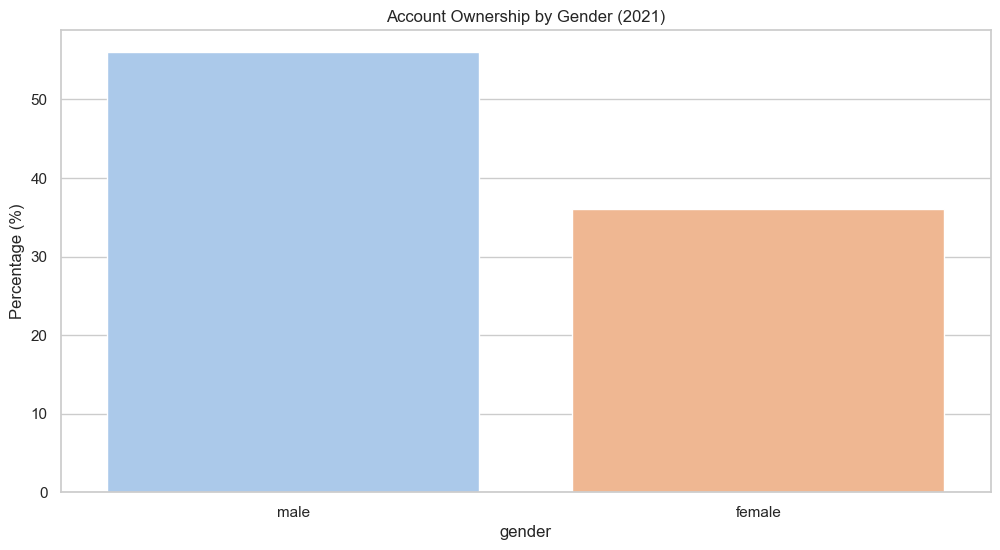

The gender gap in 2021 was 20.0 percentage points.


In [12]:
gender_df = df[df['indicator_code'] == 'ACC_OWNERSHIP']
gender_df = gender_df[gender_df['gender'].isin(['male', 'female'])]

sns.barplot(data=gender_df, x='gender', y='value_numeric', palette='pastel')
plt.title("Account Ownership by Gender (2021)")
plt.ylabel("Percentage (%)")
plt.show()

male_val = gender_df[gender_df['gender'] == 'male']['value_numeric'].values[0]
female_val = gender_df[gender_df['gender'] == 'female']['value_numeric'].values[0]
print(f"The gender gap in 2021 was {male_val - female_val} percentage points.")

## 3. Usage Analysis: Mobile Money Penetration
Analyzing the trend from 2014 to 2024.

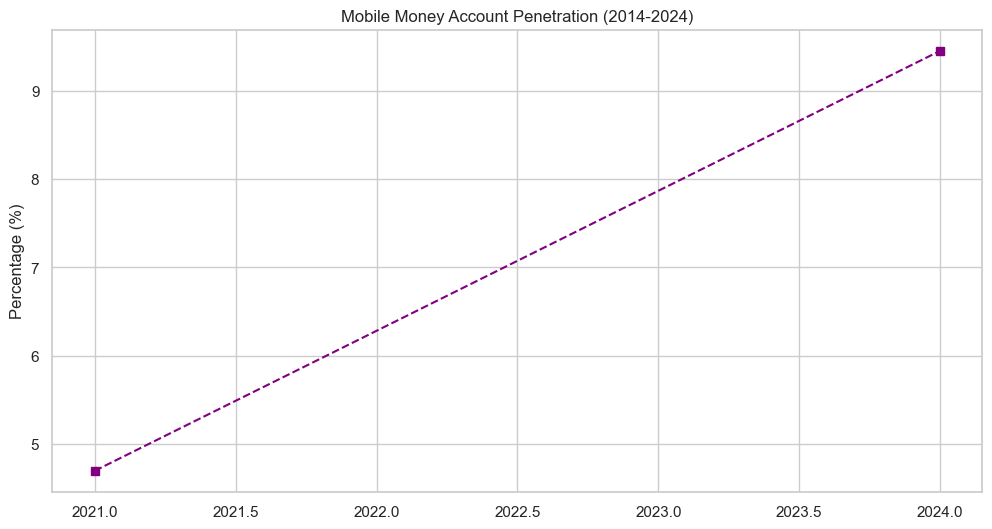

In [13]:
mm_df = obs_df[obs_df['indicator_code'] == 'ACC_MM_ACCOUNT'].sort_values('year')

plt.plot(mm_df['year'], mm_df['value_numeric'], marker='s', linestyle='--', color='purple')
plt.title("Mobile Money Account Penetration (2014-2024)")
plt.ylabel("Percentage (%)")
plt.show()

## 4. Infrastructure vs. Inclusion
Examining relations between 4G coverage and digital payment adoption.

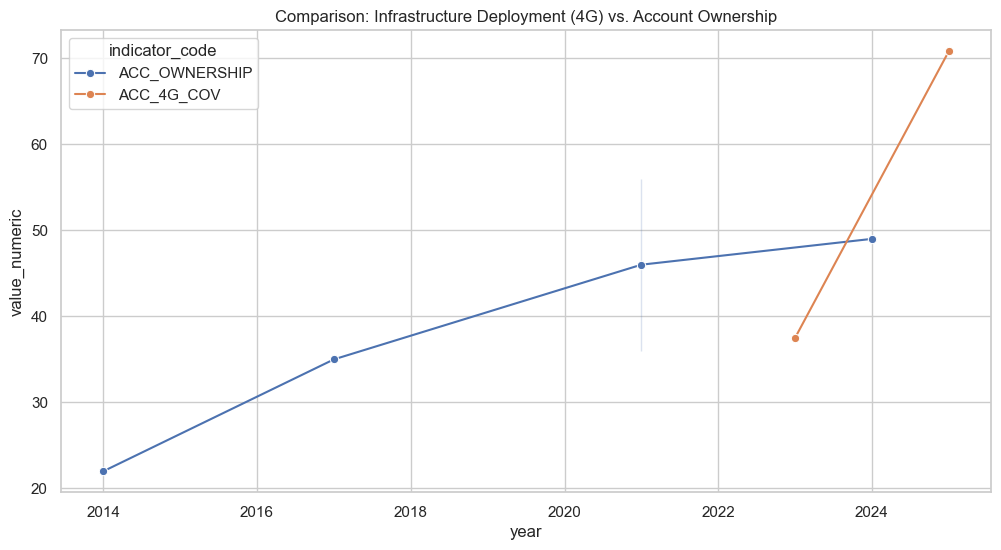

In [14]:
# Comparison: 4G Coverage vs. Account Ownership
sns.lineplot(data=obs_df[obs_df['indicator_code'].isin(['ACC_OWNERSHIP', 'ACC_4G_COV'])], x='year', y='value_numeric', hue='indicator_code', marker='o')
plt.title("Comparison: Infrastructure Deployment (4G) vs. Account Ownership")
plt.show()

## 5. Event Timeline Analysis
Mapping policies and launches against the backdrop of changing indicators.

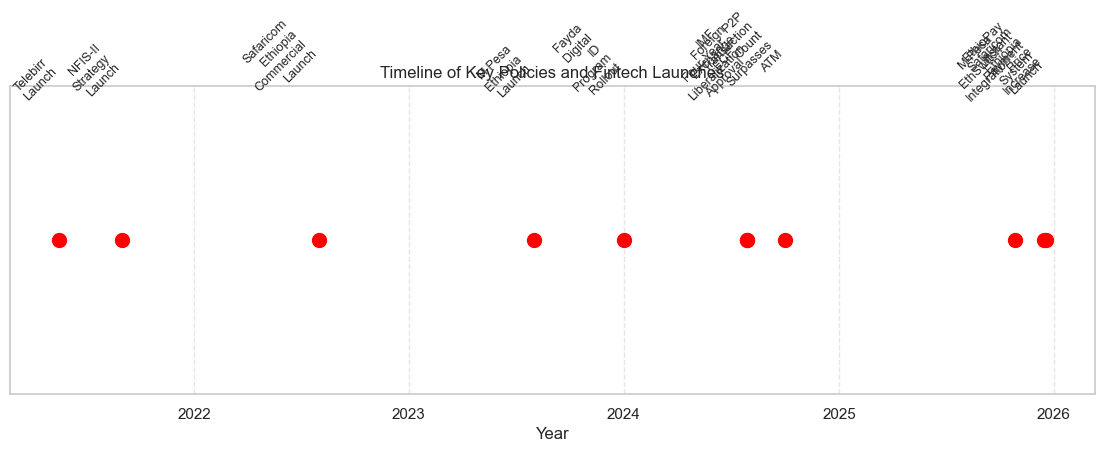

In [15]:
events_df = df[df['record_type'] == 'event'].copy()
events_df['observation_date'] = pd.to_datetime(events_df['observation_date'])

plt.figure(figsize=(14, 4))
plt.scatter(events_df['observation_date'], [1]*len(events_df), c='red', s=100, label='Events')

for i, row in events_df.iterrows():
    plt.text(row['observation_date'], 1.05, row['indicator'].replace(' ', '\n'), rotation=45, ha='right', fontsize=9)

plt.yticks([])
plt.title("Timeline of Key Policies and Fintech Launches")
plt.xlabel("Year")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

## 6. Investigating the 2021-2024 Slowdown
Despite 60M+ mobile money accounts being opened, inclusion grew only 3pp. Why?

**Hypothesis 1**: Mobile money is an add-on for bank users, not an entry point.
**Hypothesis 2**: P2P Dominance - Users use it for transfers but don't consider it 'account ownership'.

In [16]:
# Telebirr users vs Adult population
telebirr = df[df['indicator_code'] == 'USG_TELEBIRR_USERS']['value_numeric'].iloc[0]
adult_pop = 130000000 * 0.55

reg_rate = (telebirr / adult_pop) * 100
print(f"Telebirr Registration Rate (vs adult pop): {reg_rate:.2f}%")
print(f"Actual Account Ownership (Findex): 49.0%")

Telebirr Registration Rate (vs adult pop): 76.70%
Actual Account Ownership (Findex): 49.0%
